**Fine Tuning**

**Training the pre-trained model with weighted class Cross-Entropy Loss Function**

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import numpy as np
import cv2
import os
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import seaborn as sns

C:\Users\subha\anaconda3\Lib\site-packages\torch\utils\_pytree.py:185: FutureWarning: optree is installed but the version is too old to support PyTorch Dynamo in C++ pytree. C++ pytree support is disabled. Please consider upgrading optree using `python3 -m pip install --upgrade 'optree>=0.13.0'`.
  warnings.warn(


In [ ]:
# ------------------------
# 1. Dataset Class
# ------------------------
class CityscapesDataset(Dataset):
    def __init__(self, image_paths, mask_paths):
        self.image_paths = image_paths
        self.mask_paths = mask_paths
        self.transform = transforms.Compose([
            transforms.ToTensor(),
        ])
        
    def __len__(self):
        return len(self.image_paths)
    
    def __getitem__(self, idx):
        # Load image
        img = np.load(self.image_paths[idx])
        img = self.transform(img).float()
        
        # Load mask
        mask = cv2.imread(self.mask_paths[idx], cv2.IMREAD_GRAYSCALE)
        mask = torch.from_numpy(mask).long()  # CrossEntropyLoss needs LongTensor
        
        # Verify shapes and values
        assert img.shape == (3, 256, 256), f"Invalid image shape: {img.shape}"
        assert mask.shape == (256, 256), f"Invalid mask shape: {mask.shape}"
        assert mask.max() <= 6 and mask.min() >= 0, "Mask values out of range 0-6"
        
        return img, mask

# ------------------------
# 2. U-Net Model
# ------------------------
class DoubleConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, 3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, 3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )
        
    def forward(self, x):
        return self.conv(x)

class UNet(nn.Module):
    def __init__(self, in_channels=3, out_channels=7):
        super().__init__()
        # Encoder
        self.down1 = DoubleConv(in_channels, 64)
        self.down2 = DoubleConv(64, 128)
        self.down3 = DoubleConv(128, 256)
        self.pool = nn.MaxPool2d(2)
        
        # Bottleneck
        self.bottleneck = DoubleConv(256, 512)
        
        # Decoder
        self.up1 = nn.ConvTranspose2d(512, 256, 2, stride=2)
        self.conv1 = DoubleConv(512, 256)
        self.up2 = nn.ConvTranspose2d(256, 128, 2, stride=2)
        self.conv2 = DoubleConv(256, 128)
        self.up3 = nn.ConvTranspose2d(128, 64, 2, stride=2)
        self.conv3 = DoubleConv(128, 64)
        
        # Output
        self.final = nn.Conv2d(64, out_channels, 1)
        
    def forward(self, x):
        # Encoder
        x1 = self.down1(x)          # 64
        x2 = self.pool(x1)
        x2 = self.down2(x2)         # 128
        x3 = self.pool(x2)
        x3 = self.down3(x3)         # 256
        x4 = self.pool(x3)
        
        # Bottleneck
        x4 = self.bottleneck(x4)    # 512
        
        # Decoder
        x = self.up1(x4)            # 256
        x = torch.cat([x, x3], dim=1)
        x = self.conv1(x)
        
        x = self.up2(x)             # 128
        x = torch.cat([x, x2], dim=1)
        x = self.conv2(x)
        
        x = self.up3(x)             # 64
        x = torch.cat([x, x1], dim=1)
        x = self.conv3(x)
        
        return self.final(x)

# ------------------------
# 3. Training Setup
# ------------------------
def train_model(pretrained_path=None, class_weights=None):
    # Initialize datasets
    train_dataset = CityscapesDataset(train_image_paths, train_mask_paths)
    val_dataset = CityscapesDataset(val_image_paths, val_mask_paths)
    
    # Create dataloaders
    train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=8)
    
    # Model setup
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model = UNet().to(device)
    
    # Load pretrained weights if available
    if pretrained_path:
        model.load_state_dict(torch.load(pretrained_path))
        print(f"Loaded pretrained model from {pretrained_path}")
    
    # Loss function with class weighting
    if class_weights is not None:
        class_weights = class_weights.to(device)
    criterion = nn.CrossEntropyLoss(weight=class_weights)
    
    # Optimizer with reduced learning rate for fine-tuning
    optimizer = optim.Adam(model.parameters(), lr=1e-5)  # Smaller LR for fine-tuning
    
    best_iou = 0  # Track best mean IoU
    class_iou_history = []  # Store IoU per class per epoch
    
    for epoch in range(30):
        # Training
        model.train()
        train_loss = 0
        for images, masks in train_loader:
            images, masks = images.to(device), masks.to(device)
            
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, masks)
            loss.backward()
            optimizer.step()
            
            train_loss += loss.item()
        
        # Validation with per-class IoU
        model.eval()
        val_loss = 0
        val_ious = []  # Store IoU for each batch
        
        with torch.no_grad():
            for images, masks in val_loader:
                images, masks = images.to(device), masks.to(device)
                outputs = model(images)
                val_loss += criterion(outputs, masks).item()
                
                # Calculate per-class IoU for this batch
                preds = torch.argmax(outputs, dim=1)
                ious = calculate_per_class_iou(model, [(images, masks)], num_classes=7, device=device)
                val_ious.append(ious)
        
        # Calculate metrics
        avg_train_loss = train_loss / len(train_loader)
        avg_val_loss = val_loss / len(val_loader)
        mean_val_iou = np.mean(val_ious)  # Mean across all classes
        
        # Print detailed progress
        print(f'\nEpoch {epoch+1:03} | Train Loss: {avg_train_loss:.4f} | Val Loss: {avg_val_loss:.4f}')
        print('Per-Class IoU:')
        for i, iou in enumerate(np.mean(val_ious, axis=0)):
            print(f'  Class {i}: {iou:.4f}', end=' | ')
        
        # Save best model based on mean IoU
        if mean_val_iou > best_iou:
            best_iou = mean_val_iou
            torch.save(model.state_dict(), 'new_best_model.pth')
            print(f'\nNew best model saved with mean IoU {best_iou:.4f}')
        
        # Store class IoUs for analysis
        class_iou_history.append(np.mean(val_ious, axis=0))
    
    return model, class_iou_history

    
# ------------------------
# 4. Evaluation & Inference
# ------------------------
def evaluate(model, test_loader, device):
    model.eval()
    total_correct = 0
    total_pixels = 0
    
    with torch.no_grad():
        for images, masks in test_loader:
            images = images.to(device)
            masks = masks.to(device)
            outputs = model(images)
            
            _, preds = torch.max(outputs, 1)
            total_correct += (preds == masks).sum().item()
            total_pixels += torch.numel(masks)
    
    accuracy = total_correct / total_pixels
    print(f'Test Accuracy: {accuracy:.4f}')

def visualize_predictions(model, dataset, device, n_samples=3):
    indices = np.random.choice(len(dataset), n_samples)
    model.eval()
    
    plt.figure(figsize=(15, 5*n_samples))
    for i, idx in enumerate(indices):
        image, mask = dataset[idx]
        with torch.no_grad():
            output = model(image.unsqueeze(0).to(device))
            pred = torch.argmax(output.squeeze(), dim=0).cpu()
        
        plt.subplot(n_samples, 3, i*3+1)
        plt.imshow(image.permute(1, 2, 0))
        plt.title('Input Image')
        
        plt.subplot(n_samples, 3, i*3+2)
        plt.imshow(mask)
        plt.title('True Mask')
        
        plt.subplot(n_samples, 3, i*3+3)
        plt.imshow(pred)
        plt.title('Predicted Mask')
    
    plt.tight_layout()
    plt.show()

def calculate_per_class_iou(model, dataloader, num_classes, device):
    model.eval()
    model.to(device)
    
    # Initialize confusion matrix
    cm = np.zeros((num_classes, num_classes))
    
    with torch.no_grad():
        for images, masks in dataloader:
            # Move data to the same device as model
            images = images.to(device)
            masks = masks.to(device)
            
            outputs = model(images)
            preds = torch.argmax(outputs, dim=1)
            
            # Update confusion matrix
            masks_np = masks.cpu().numpy().flatten()
            preds_np = preds.cpu().numpy().flatten()
            
            for lt, lp in zip(masks_np, preds_np):
                cm[lt][lp] += 1
    
    # Calculate IoU for each class
    ious = []
    for i in range(num_classes):
        tp = cm[i,i]
        fp = cm[:,i].sum() - tp
        fn = cm[i,:].sum() - tp
        iou = tp / (tp + fp + fn + 1e-6)  # Add small epsilon to avoid division by zero
        ious.append(iou)
    
    return ious
# ------------------------
# Usage Instructions
# ------------------------
if __name__ == '__main__':

    train_image_dir = "/kaggle/input/cityscapes/output/Images_processed/train"
    train_mask_dir = "/kaggle/input/cityscapes/output/masks_processed/train"
    val_image_dir = "/kaggle/input/cityscapes/output/Images_processed/val"
    val_mask_dir = "/kaggle/input/cityscapes/output/masks_processed/val"

    all_train_images = sorted([f for f in os.listdir(train_image_dir) if f.endswith('.npy')])
    all_train_masks = sorted([f for f in os.listdir(train_mask_dir) if f.endswith('.png')])

    
    all_val_images = sorted([f for f in os.listdir(val_image_dir) if f.endswith('.npy')])
    all_val_masks = sorted([f for f in os.listdir(val_mask_dir) if f.endswith('.png')])

    # Split indices instead of filenames (ensures 1:1 mapping)
    indices = np.arange(len(all_val_images))
    test_indices, val_indices = train_test_split(indices, test_size=0.5, random_state=42)

    # Create separate path lists
    test_image_paths = [os.path.join(val_image_dir, all_val_images[i]) for i in test_indices]
    test_mask_paths = [os.path.join(val_mask_dir, all_val_masks[i]) for i in test_indices]

    val_image_paths = [os.path.join(val_image_dir, all_val_images[i]) for i in val_indices]
    val_mask_paths = [os.path.join(val_mask_dir, all_val_masks[i]) for i in val_indices]

    train_image_paths=[os.path.join(train_image_dir, all_train_images[i]) for i in range(len(all_train_images))]
    train_mask_paths=[os.path.join(train_mask_dir, all_train_masks[i]) for i in range(len(all_train_masks))]
    
                      
    # Verify no overlap
    assert len(set(test_image_paths) & set(val_image_paths)) == 0
    print(f"Test set: {len(test_image_paths)} samples")
    print(f"Val set: {len(val_image_paths)} samples")
    
    # 2. Train the model
    #train_model()

    # Example if class 4 has 5% of total pixels:
    class_frequencies = [0.21, 0.33, 0.20, 0.07, 0.01, 0.14, 0.04]  # Must sum to 1
    class_weights = 1 / torch.sqrt(torch.tensor(class_frequencies))  # More stable than linear

    model, iou_history = train_model(
    pretrained_path='/kaggle/input/unet1model/best_model.pth',
    class_weights=class_weights
)
    
    

**Class Ious and accuracy on the trained model**

In [4]:
   # . Load best model for evaluation
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model = UNet().to(device)
    model.load_state_dict(torch.load('C:/Users/subha/Downloads/new_best_model.pth',map_location=torch.device('cpu')))
    
    # . Evaluate on test set
    test_dataset = CityscapesDataset(test_image_paths, test_mask_paths)
    test_loader = DataLoader(test_dataset, batch_size=8)
    evaluate(model, test_loader, device)


    #evaluation per class
    class_ious = calculate_per_class_iou(model, test_loader, num_classes=7, device=device)



    for class_idx, iou in enumerate(class_ious):
        print(f"Class {class_idx}: IoU = {iou:.4f}")


Test Accuracy: 0.8988
Class 0: IoU = 0.6801
Class 1: IoU = 0.9066
Class 2: IoU = 0.8078
Class 3: IoU = 0.8139
Class 4: IoU = 0.4792
Class 5: IoU = 0.8595
Class 6: IoU = 0.8701


**Occluded Augmentation added and trained on the current best model**

In [ ]:

# ------------------------
# 1.Updated Dataset Class
# ------------------------
class CityscapesDataset(Dataset):
    def __init__(self, image_paths, mask_paths, augment=False):
        self.image_paths = image_paths
        self.mask_paths = mask_paths
        self.augment = augment
        self.transform = transforms.Compose([
            transforms.ToTensor(),
        ])
        
    def __len__(self):
        return len(self.image_paths)
    
    def __getitem__(self, idx):
        # Load image
        img = np.load(self.image_paths[idx])
        mask = cv2.imread(self.mask_paths[idx], cv2.IMREAD_GRAYSCALE)
        
        if self.augment:
            img = self.apply_person_occlusion(img, mask)

        img = self.transform(img).float()
        mask = torch.from_numpy(mask).long()
        
        assert img.shape == (3, 256, 256)
        assert mask.shape == (256, 256)
        assert mask.max() <= 6 and mask.min() >= 0
        
        return img, mask

    def apply_person_occlusion(self, img, mask):
        # Find person instances using connected components
        person_mask = (mask == 4).astype(np.uint8)
        num_labels, labels, stats, _ = cv2.connectedComponentsWithStats(person_mask, connectivity=8)
        
        if num_labels < 2:  # No person instances found
            return img

        # Occlusion parameters
        max_occlusions = 2
        occ_count = 0
        
        for i in range(1, num_labels):  # Skip background
            if occ_count >= max_occlusions:
                break
                
            # Get instance coordinates
            x = stats[i, cv2.CC_STAT_LEFT]
            y = stats[i, cv2.CC_STAT_TOP]
            w = stats[i, cv2.CC_STAT_WIDTH]
            h = stats[i, cv2.CC_STAT_HEIGHT]
            
            # Randomly decide to occlude this instance (60% probability)
            if np.random.rand() > 0.6:
                continue

            # Generate occlusion parameters
            occ_w = int(w * np.random.uniform(0.3, 0.7))
            occ_h = int(h * np.random.uniform(0.3, 0.7))
            x1 = x + np.random.randint(0, max(1, w - occ_w))
            y1 = y + np.random.randint(0, max(1, h - occ_h))
            
            # Apply realistic-looking occlusion (vehicle-like or random)
            if np.random.rand() < 0.7:  # 70% chance for vehicle-like occlusion
                # Create metallic color pattern
                occlusion = np.random.normal(loc=0.5, scale=0.1, size=(occ_h, occ_w, 3))
                occlusion = np.clip(occlusion, 0, 1)
            else:  # 30% random noise
                occlusion = np.random.uniform(0, 1, (occ_h, occ_w, 3))
            
            # Apply occlusion to image
            try:
                img[y1:y1+occ_h, x1:x1+occ_w] = occlusion
                occ_count += 1
            except:
                pass  # Handle edge cases
            
        return img

def visualize_occlusions(dataset, n_samples=3):
    indices = np.random.choice(len(dataset), n_samples)
    
    plt.figure(figsize=(15, 5*n_samples))
    for i, idx in enumerate(indices):
        image, mask = dataset[idx]
        
        plt.subplot(n_samples, 3, i*3+1)
        plt.imshow(image.permute(1, 2, 0))
        plt.title('Original Image')
        
        plt.subplot(n_samples, 3, i*3+2)
        plt.imshow(mask)
        plt.title('True Mask')
        
        # Create augmented version
        aug_image = dataset.apply_person_occlusion(
            image.permute(1, 2, 0).numpy().copy(),
            mask.numpy().copy()
        )
        
        plt.subplot(n_samples, 3, i*3+3)
        plt.imshow(aug_image)
        plt.title('Augmented Image')
    
    plt.tight_layout()
    plt.show()
# ------------------------
# 3. Training Setup
# ------------------------
def train_model(pretrained_path=None, class_weights=None):
    # Initialize datasets
    train_dataset = CityscapesDataset(train_image_paths, train_mask_paths, augment=True) # Enable augmentation
    val_dataset = CityscapesDataset(val_image_paths, val_mask_paths)
    
    # Create dataloaders
    train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=8)
    
    # Model setup
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model = UNet().to(device)
    
    # Load pretrained weights if available
    if pretrained_path:
        model.load_state_dict(torch.load(pretrained_path))
        print(f"Loaded pretrained model from {pretrained_path}")
    
    # Loss function with class weighting
    if class_weights is not None:
        class_weights = class_weights.to(device)
    criterion = nn.CrossEntropyLoss(weight=class_weights)
    
    # Optimizer with reduced learning rate for fine-tuning
    optimizer = optim.Adam(model.parameters(), lr=1e-5)  # Smaller LR for fine-tuning
    
    best_iou = 0  # Track best mean IoU
    class_iou_history = []  # Store IoU per class per epoch
    
    for epoch in range(30):
        # Training
        model.train()
        train_loss = 0
        for images, masks in train_loader:
            images, masks = images.to(device), masks.to(device)
            
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, masks)
            loss.backward()
            optimizer.step()
            
            train_loss += loss.item()
        
        # Validation with per-class IoU
        model.eval()
        val_loss = 0
        val_ious = []  # Store IoU for each batch
        
        with torch.no_grad():
            for images, masks in val_loader:
                images, masks = images.to(device), masks.to(device)
                outputs = model(images)
                val_loss += criterion(outputs, masks).item()
                
                # Calculate per-class IoU for this batch
                preds = torch.argmax(outputs, dim=1)
                ious = calculate_per_class_iou(model, [(images, masks)], num_classes=7, device=device)
                val_ious.append(ious)
        
        # Calculate metrics
        avg_train_loss = train_loss / len(train_loader)
        avg_val_loss = val_loss / len(val_loader)
        mean_val_iou = np.mean(val_ious)  # Mean across all classes
        
        # Print detailed progress
        print(f'\nEpoch {epoch+1:03} | Train Loss: {avg_train_loss:.4f} | Val Loss: {avg_val_loss:.4f}')
        print('Per-Class IoU:')
        for i, iou in enumerate(np.mean(val_ious, axis=0)):
            print(f'  Class {i}: {iou:.4f}', end=' | ')
        
        # Save best model based on mean IoU
        if mean_val_iou > best_iou:
            best_iou = mean_val_iou
            torch.save(model.state_dict(), 'new_best_model_2.pth')
            print(f'\nNew best model saved with mean IoU {best_iou:.4f}')
        
        # Store class IoUs for analysis
        class_iou_history.append(np.mean(val_ious, axis=0))
    
    return model, class_iou_history

    
if __name__ == '__main__':
  
    train_image_dir = "/kaggle/input/cityscapes/output/Images_processed/train"
    train_mask_dir = "/kaggle/input/cityscapes/output/masks_processed/train"
    val_image_dir = "/kaggle/input/cityscapes/output/Images_processed/val"
    val_mask_dir = "/kaggle/input/cityscapes/output/masks_processed/val"

    all_train_images = sorted([f for f in os.listdir(train_image_dir) if f.endswith('.npy')])
    all_train_masks = sorted([f for f in os.listdir(train_mask_dir) if f.endswith('.png')])

    
    all_val_images = sorted([f for f in os.listdir(val_image_dir) if f.endswith('.npy')])
    all_val_masks = sorted([f for f in os.listdir(val_mask_dir) if f.endswith('.png')])

    # Split indices instead of filenames (ensures 1:1 mapping)
    indices = np.arange(len(all_val_images))
    test_indices, val_indices = train_test_split(indices, test_size=0.5, random_state=42)

    # Create separate path lists
    test_image_paths = [os.path.join(val_image_dir, all_val_images[i]) for i in test_indices]
    test_mask_paths = [os.path.join(val_mask_dir, all_val_masks[i]) for i in test_indices]

    val_image_paths = [os.path.join(val_image_dir, all_val_images[i]) for i in val_indices]
    val_mask_paths = [os.path.join(val_mask_dir, all_val_masks[i]) for i in val_indices]

    train_image_paths=[os.path.join(train_image_dir, all_train_images[i]) for i in range(len(all_train_images))]
    train_mask_paths=[os.path.join(train_mask_dir, all_train_masks[i]) for i in range(len(all_train_masks))]
    
                      

    # Example if class 4 has 5% of total pixels:
    class_frequencies = [0.21, 0.33, 0.20, 0.06, 0.02, 0.14, 0.04]  # Must sum to 1
    class_weights = 1 / torch.sqrt(torch.tensor(class_frequencies))  # More stable than linear

    model, iou_history = train_model(
    pretrained_path='/kaggle/input/unet1model/new_best_model.pth',
    class_weights=class_weights
)
    #train_dataset = CityscapesDataset(train_image_paths, train_mask_paths, augment=True)
    visualize_occlusions(train_dataset)

In [11]:
  
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model = UNet().to(device)
    model.load_state_dict(torch.load('C:/Users/subha/Downloads/new_best_model_2.pth',map_location=torch.device('cpu')))
    
    # . Evaluate on test set
    test_dataset = CityscapesDataset(test_image_paths, test_mask_paths)
    test_loader = DataLoader(test_dataset, batch_size=8)
    evaluate(model, test_loader, device)


    #evaluation per class
    class_ious = calculate_per_class_iou(model, test_loader, num_classes=7, device=device)



    for class_idx, iou in enumerate(class_ious):
        print(f"Class {class_idx}: IoU = {iou:.4f}")


Test Accuracy: 0.8998
Class 0: IoU = 0.6842
Class 1: IoU = 0.9082
Class 2: IoU = 0.8075
Class 3: IoU = 0.8128
Class 4: IoU = 0.4893
Class 5: IoU = 0.8592
Class 6: IoU = 0.8784


**Confusion MAtrix and Class distribution for the new best model**

/tmp/ipykernel_31/1480735461.py:401: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('/kaggle/input/new-best-model-2/new_best_model_2.pth'))


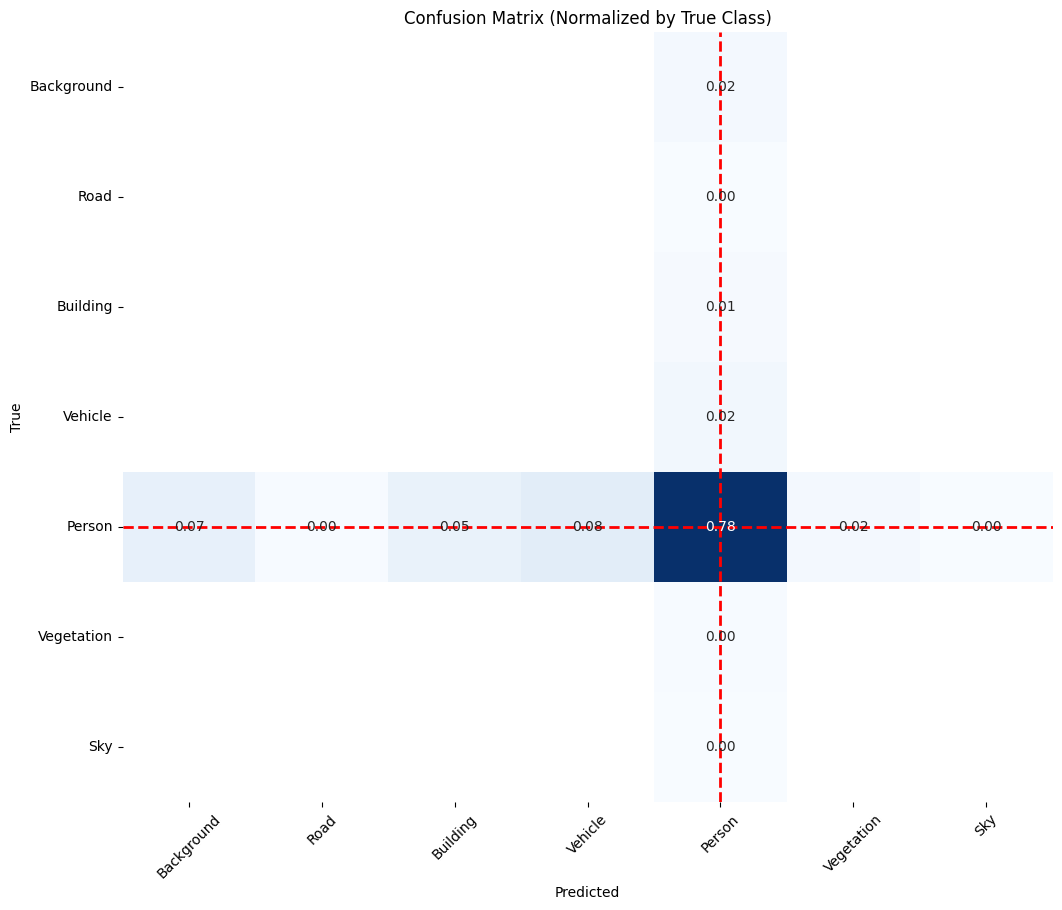

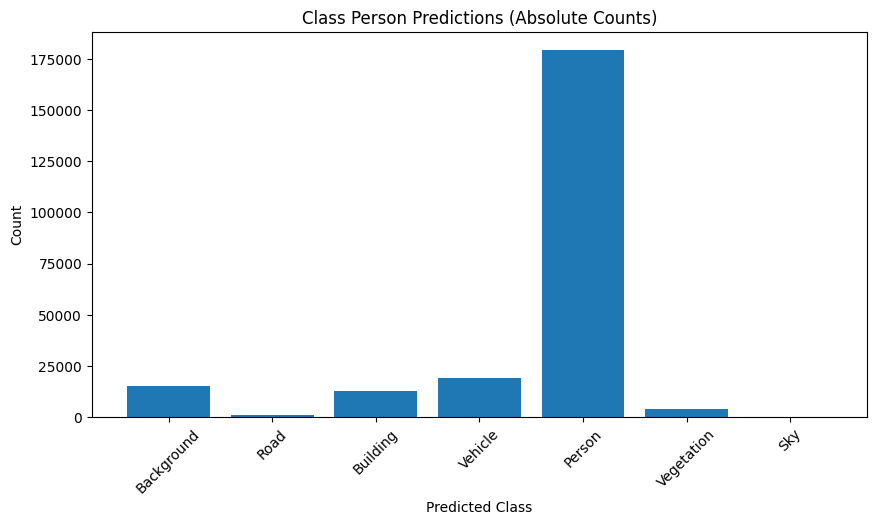

In [1]:
def calculate_confusion_matrix(model, dataloader, num_classes, device):
    model.eval()
    cm = np.zeros((num_classes, num_classes), dtype=np.int64)
    
    with torch.no_grad():
        for images, masks in dataloader:
            images = images.to(device)
            masks = masks.to(device)
            
            outputs = model(images)
            preds = torch.argmax(outputs, dim=1)
            
            # Flatten and convert to numpy
            masks_np = masks.cpu().numpy().flatten()
            preds_np = preds.cpu().numpy().flatten()
            
            # Update confusion matrix
            np.add.at(cm, (masks_np, preds_np), 1)
    
    return cm




def plot_confusion_matrix(cm, class_names, focus_class=None):
    plt.figure(figsize=(12, 10))
    
    # Normalize by true class counts
    cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    
    # Create mask for focus class if specified
    mask = np.zeros_like(cm_normalized) if focus_class is None else None
    if focus_class is not None:
        mask = np.ones_like(cm_normalized)
        mask[focus_class, :] = 0  # Show full row for focus class
        mask[:, focus_class] = 0  # Show full column for focus class
    
    # Plot with annotations
    sns.heatmap(cm_normalized, annot=True, fmt=".2f", cmap='Blues',
                mask=mask, cbar=False,
                xticklabels=class_names, 
                yticklabels=class_names)
    
    plt.title('Confusion Matrix (Normalized by True Class)')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.xticks(rotation=45)
    plt.yticks(rotation=0)
    
    if focus_class is not None:
        plt.gca().axhline(focus_class+0.5, color='red', linestyle='--', linewidth=2)
        plt.gca().axvline(focus_class+0.5, color='red', linestyle='--', linewidth=2)
    
    plt.show()

    # Plot absolute counts for focus class
    if focus_class is not None:
        plt.figure(figsize=(10, 5))
        plt.bar(class_names, cm[focus_class])
        plt.title(f'Class {class_names[focus_class]} Predictions (Absolute Counts)')
        plt.xlabel('Predicted Class')
        plt.ylabel('Count')
        plt.xticks(rotation=45)
        plt.show()
# ------------------------
# Usage Instructions
# ------------------------
if __name__ == '__main__':
   
    val_dataset = CityscapesDataset(val_image_paths, val_mask_paths)
    val_loader = DataLoader(val_dataset, batch_size=8)

    # Class names based on your setup
    class_names = ['Background', 'Road', 'Building', 'Vehicle', 'Person', 'Vegetation', 'Sky']

# Calculate confusion matrix
    cm = calculate_confusion_matrix(model, val_loader, num_classes=7, device=device)

# Plot full matrix and focus on Person (class 4)
    plot_confusion_matrix(cm, class_names, focus_class=4)
